In [1]:
%pylab inline
figsize(8, 6)

Populating the interactive namespace from numpy and matplotlib


##Import

In [2]:
import pandas
import numexpr
import numpy
from rep_ef.estimators import MatrixNetSkyGridClassifier
from rep.metaml import FoldingClassifier
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
from utils import get_N_B_events, get_events_number, get_events_statistics

## Reading initial data

In [4]:
data_nan = pandas.read_csv('datasets/Tracks.csv', sep='\t')

In [5]:
data_nan.head()

,run,event,Bmass,i,mult,partP,partPt,ptB,IPs,IP,...,proj,ID,veloch,signB,signTrack,Dist_phi,N_sig_sw,mu_cut,e_cut,K_cut
0,115839,204997902,5.309576,0,13,3.67156,0.300418,4.004197,0.816143,0.056365,...,1.058442,-211,0.911645,1,-1,0.114615,0.59521,0,0,0
1,115839,204997902,5.309576,1,13,8.33952,1.103876,4.004197,1.375382,0.033095,...,3.121358,-211,0.796731,1,-1,0.051334,0.59521,0,0,0
2,115839,204997902,5.309576,2,13,8.37654,1.182519,4.004197,4.338812,0.077636,...,10.585135,-211,0.946629,1,-1,1.856516,0.59521,0,0,0
3,115839,204997902,5.309576,3,13,25.72961,0.905010,4.004197,2.287509,0.086603,...,7.485243,211,1.058989,1,1,0.577419,0.59521,0,0,0
4,115839,204997902,5.309576,4,13,3.70597,0.516123,4.004197,0.562424,0.015694,...,5.617354,211,1.042135,1,1,1.314513,0.59521,0,0,0


In [6]:
event_id_column = 'event_id'
data_nan[event_id_column] = data_nan.run.apply(str) + '_' + data_nan.event.apply(str)

In [7]:
get_events_statistics(data_nan)

{'Events': 1005757, 'tracks': 27156193}

In [8]:
get_N_B_events()

742867.7142562866

## Remove rows with NAN from data

In [9]:
data = data_nan.dropna()
len(data_nan), len(data), get_events_statistics(data)

(27156193, 27156190, {'Events': 1005757, 'tracks': 27156190})

## Add diff_pt and cos(diff_phi)

In [10]:
# add different between max pt in event and pt for each track
def add_diff_pt(data):
    max_pt = group_max(data[event_id_column].values.astype(str), data.partPt.values)
    data['diff_pt'] = max_pt - data['partPt'].values

# max is computing max over tracks in the same event for saome data
def group_max(groups, data):
    # computing unique integer id for each group
    assert len(groups) == len(data)
    _, event_id = numpy.unique(groups, return_inverse=True)
    max_over_event = numpy.zeros(max(event_id) + 1) - numpy.inf
    numpy.maximum.at(max_over_event, event_id, data)
    return max_over_event[event_id]

In [11]:
# add diff pt
add_diff_pt(data)
# add cos(diff_phi)
data['cos_diff_phi'] = numpy.cos(data.diff_phi.values)

## Add max, sum among PIDs

In [12]:
from itertools import combinations
PIDs = {'k': data.PIDNNk.values,
        'e': data.PIDNNe.values,
        'mu': data.PIDNNm.values,
       }
for (pid_name1, pid_values1), (pid_name2, pid_values2) in combinations(PIDs.items(), 2):
    data['max_PID_{}_{}'.format(pid_name1, pid_name2)] = numpy.maximum(pid_values1, pid_values2)
    data['sum_PID_{}_{}'.format(pid_name1, pid_name2)] = pid_values1 + pid_values2

## define `label` = `signB` * `signTrack`

* if > 0 (same sign) - label **1**
* if < 0 (different sign) - label **0**

In [13]:
data['label'] = (data.signB.values * data.signTrack.values > 0) * 1

In [14]:
','.join(data.columns)

'run,event,Bmass,i,mult,partP,partPt,ptB,IPs,IP,IPerr,partlcs,EOverP,ghostProb,IPPU,nnkrec,PIDNNk,PIDNNpi,PIDNNp,PIDNNm,PIDNNe,diff_eta,diff_phi,phi,eta,proj,ID,veloch,signB,signTrack,Dist_phi,N_sig_sw,mu_cut,e_cut,K_cut,event_id,diff_pt,cos_diff_phi,max_PID_mu_k,sum_PID_mu_k,max_PID_mu_e,sum_PID_mu_e,max_PID_k_e,sum_PID_k_e,label'

## Filter out protons and pions, apply ghost prob cut

In [15]:
threshold_mistag = 0.6
initial_cut = '(PIDNNp < {tr}) & (PIDNNpi < {tr}) & (ghostProb < 0.4)'.format(tr=threshold_mistag)
data = data.query(initial_cut)

In [16]:
get_events_statistics(data)

{'Events': 997107, 'tracks': 9498623}

## Leave muons, kaons, electrons

In [17]:
threshold_kaon = 0.7 
threshold_muon = 0.4
threshold_electron = 0.6
cut_pid = " ( (PIDNNk > {trk}) | (PIDNNm > {trm}) | (PIDNNe > {tre}) ) "
cut_pid = cut_pid.format(trk=threshold_kaon, trm=threshold_muon, tre=threshold_electron)
    
data = data.query(cut_pid)

In [18]:
get_events_statistics(data)

{'Events': 657874, 'tracks': 1191986}

## Calculating tagging efficiency ($\epsilon_{tag}$)

$$N (\text{passed selection}) = \sum_{\text{passed selection}} sw_i$$

$$N (\text{all events}) = \sum_{\text{all events}} sw_i,$$

where $sw_i$ - sPLot weight (sWeight for signal)

$$\epsilon_{tag} = \frac{N (\text{passed selection})} {N (\text{all events})}$$

$$\Delta\epsilon_{tag} = \frac{\sqrt{N (\text{passed selection})}} {N (\text{all events})}$$

In [19]:
N_B_passed = float(get_events_number(data))
tagging_efficiency = N_B_passed / get_N_B_events()
tagging_efficiency_delta = sqrt(N_B_passed) / get_N_B_events()
tagging_efficiency, tagging_efficiency_delta

(0.6694822894448079, 0.00094932256580402023)

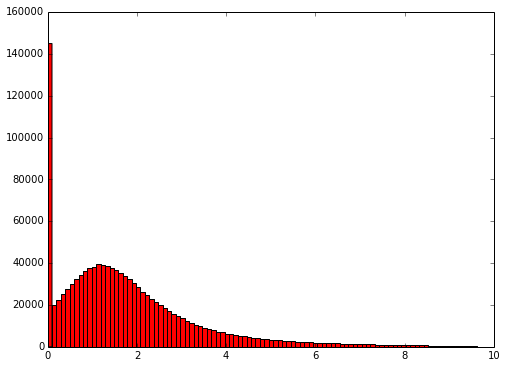

In [20]:
hist(data.diff_pt.values, bins=100)
pass

## Choose most probable B-events

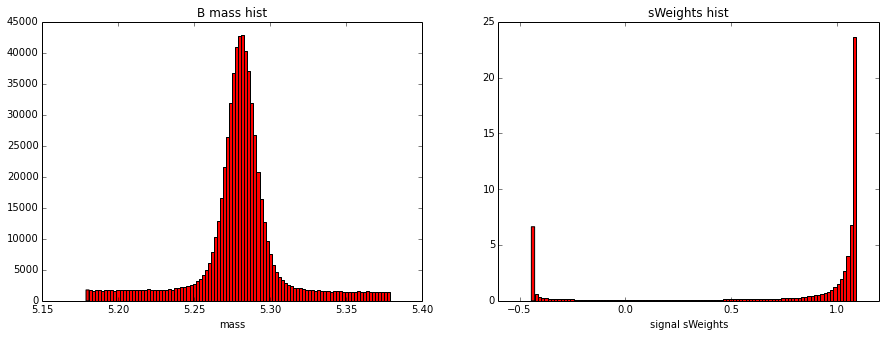

In [21]:
_, take_indices = numpy.unique(data[event_id_column], return_index=True)

figure(figsize=[15, 5])

subplot(1, 2, 1)
hist(data.Bmass.values[take_indices], bins=100)
title('B mass hist')
xlabel('mass')

subplot(1, 2, 2)
hist(data.N_sig_sw.values[take_indices], bins=100, normed=True)
title('sWeights hist')
xlabel('signal sWeights')
pass

### Define B-like events for training 

Events with low sWeight still will be used only to test quality.

In [22]:
sweight_threshold = 1.
data_sw_passed = data[data.N_sig_sw > sweight_threshold]
data_sw_not_passed = data[data.N_sig_sw <= sweight_threshold]
get_events_statistics(data_sw_passed)

{'Events': 409381, 'tracks': 743076}

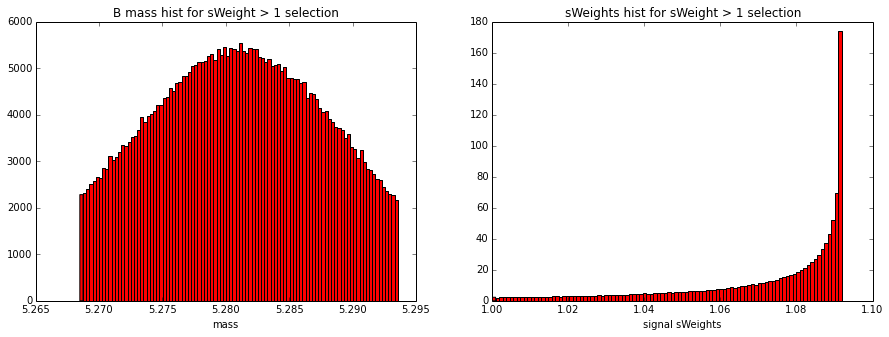

In [23]:
_, take_indices = numpy.unique(data_sw_passed[event_id_column], return_index=True)

figure(figsize=[15, 5])
subplot(1, 2, 1)
hist(data_sw_passed.Bmass.values[take_indices], bins=100)
title('B mass hist for sWeight > 1 selection')
xlabel('mass')

subplot(1, 2, 2)
hist(data_sw_passed.N_sig_sw.values[take_indices], bins=100, normed=True)
title('sWeights hist for sWeight > 1 selection')
xlabel('signal sWeights')
pass

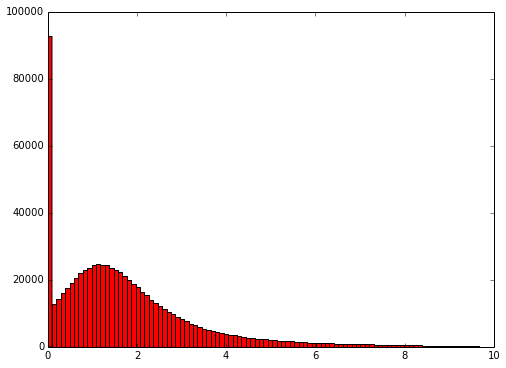

In [24]:
hist(data_sw_passed.diff_pt.values, bins=100)
pass

# Main idea: 
## find tracks, which can help reconstruct the sign of B if you know track sign.

`label` = `signB` * `signTrack`
* the highest output means that this is same sign B as track
* the lowest output means that this is opposite sign B than track

## Define features

In [25]:
features = list(set(data.columns) - {'run', 'event', 'i', 'signB', 'signTrack', 'N_sig_sw', 'Bmass', 'mult', 
                                     'PIDNNp', 'PIDNNpi', 'label', 'thetaMin', 'Dist_phi', event_id_column, 
                                     'mu_cut', 'e_cut', 'K_cut'})
features

['cos_diff_phi',
 'diff_pt',
 'partPt',
 'partP',
 'nnkrec',
 'diff_eta',
 'EOverP',
 'ptB',
 'sum_PID_mu_k',
 'proj',
 'PIDNNe',
 'sum_PID_k_e',
 'PIDNNk',
 'sum_PID_mu_e',
 'PIDNNm',
 'phi',
 'IP',
 'IPerr',
 'IPs',
 'ID',
 'veloch',
 'max_PID_k_e',
 'diff_phi',
 'ghostProb',
 'IPPU',
 'eta',
 'max_PID_mu_e',
 'max_PID_mu_k',
 'partlcs']

## PID pairs scatters

/moosefs/ipython_env/local/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


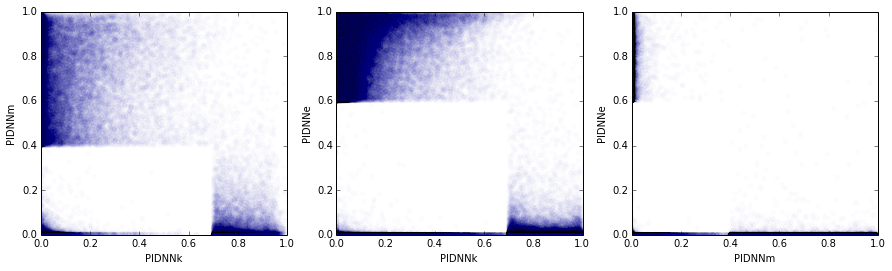

In [26]:
figure(figsize=[15, 4])
for i, (feature1, feature2) in enumerate(combinations(['PIDNNk', 'PIDNNm', 'PIDNNe'], 2)):
    subplot(1, 3, i + 1)
    scatter(data_sw_passed[feature1].values, data_sw_passed[feature2].values, alpha=0.01)
    xlabel(feature1)
    ylabel(feature2)
    ylim(0, 1), xlim(0, 1)

## pt

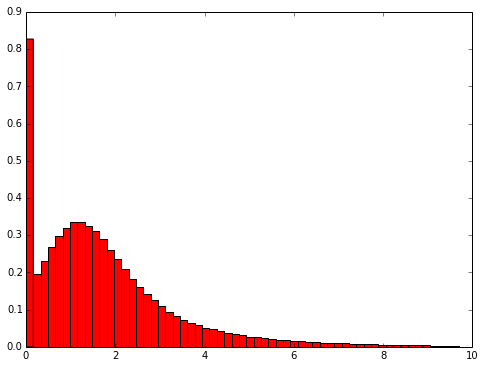

In [27]:
hist(data_sw_passed.diff_pt.values, bins=60, normed=True)
pass

## count of tracks

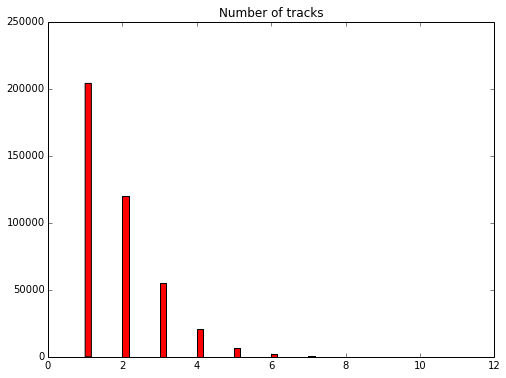

In [28]:
_, n_tracks = numpy.unique(data_sw_passed[event_id_column], return_counts=True)
hist(n_tracks, bins=60)    
title('Number of tracks')
pass

## PIDs histograms

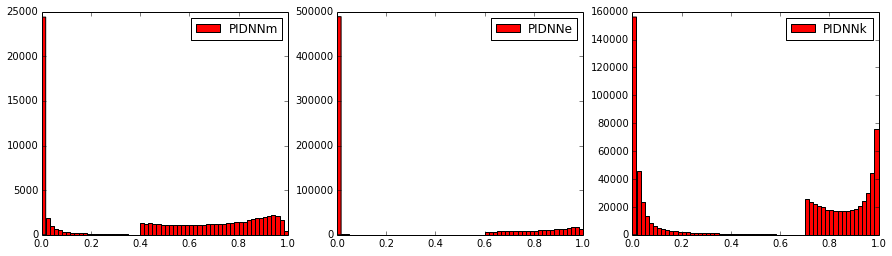

In [29]:
figure(figsize=[15, 4])
for i, column in enumerate(['PIDNNm', 'PIDNNe', 'PIDNNk']):
    subplot(1, 3, i + 1)
    hist(data_sw_passed[column].values, bins=60, range=(0, 1), label=column)
    legend()

##  Preselection of tracks using 2-folding training

In [30]:
base = RandomForestClassifier(n_estimators=300, max_depth=8, min_samples_leaf=100, n_jobs=8)
est_choose_lds = LabeledDataStorage(data_sw_passed, data_sw_passed.label, data_sw_passed.N_sig_sw)
est_choose_RT = FoldingClassifier(base, features=features, random_state=11)
%time est_choose_RT.fit_lds(est_choose_lds)
pass

CPU times: user 25min 23s, sys: 7.62 s, total: 25min 31s
Wall time: 28min 46s


In [31]:
est_choose_report = ClassificationReport({'RF': est_choose_RT}, est_choose_lds)

KFold prediction using folds column


#### ROC AUC

In [32]:
est_choose_report.compute_metric(RocAuc())

OrderedDict([('RF', 0.54768423216254969)])

#### ROC CURVE

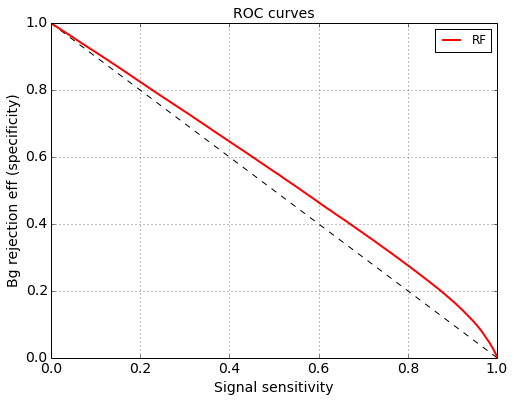

In [33]:
plot([0, 1], [1, 0], 'k--')
est_choose_report.roc()

#### Feature importances

In [34]:
imp = numpy.sum([est.feature_importances_ for est in est_choose_RT.estimators], axis=0)
imp = pandas.DataFrame({'importance': imp / numpy.max(imp), 'feature': est_choose_RT.features})
imp.sort('importance', ascending=False)

,feature,importance
18,IPs,1.000000
2,partPt,0.801011
16,IP,0.619485
17,IPerr,0.533787
1,diff_pt,0.516635
14,PIDNNm,0.479636
9,proj,0.420536
11,sum_PID_k_e,0.334248
21,max_PID_k_e,0.278921
24,IPPU,0.268276


#### Distributions for output

normalizing distribution with flattener

KFold prediction using folds column


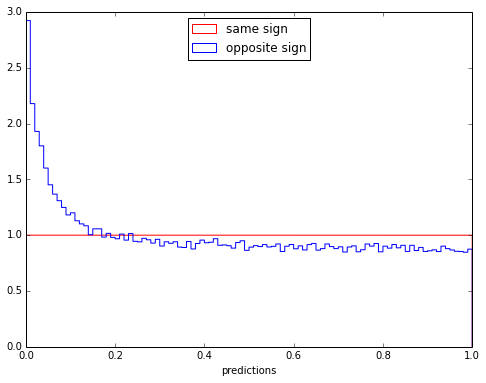

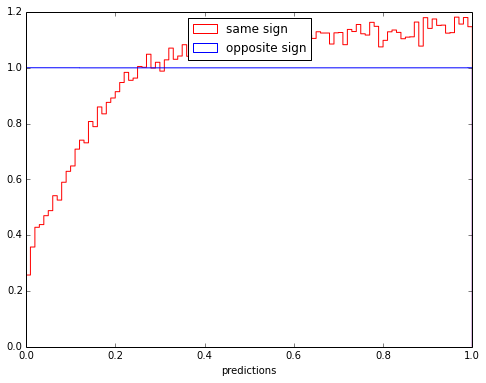

In [35]:
from utils import plot_flattened_probs
probs = est_choose_RT.predict_proba(data_sw_passed)
flat_ss = plot_flattened_probs(probs, data_sw_passed.label.values, data_sw_passed.N_sig_sw.values, label=1)
flat_os = plot_flattened_probs(probs, data_sw_passed.label.values, data_sw_passed.N_sig_sw.values, label=0)

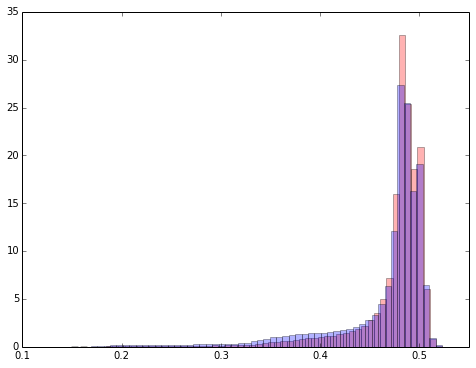

In [36]:
hist(probs[:, 1][data_sw_passed.label.values == 1], bins=60, alpha=0.3, normed=True)
hist(probs[:, 1][data_sw_passed.label.values == 0], bins=60, alpha=0.3, normed=True)
pass

#### Select top-good tracks in event

In [37]:
def get_max_ids(groups, values):
    """in each group return index of object with highest value"""
    _, groups = numpy.unique(groups, return_inverse=True)
    sorter = numpy.argsort(values)
    # languages ranked by average salaries:
    values_order = numpy.argsort(sorter)

    top_order = np.zeros(groups.max() + 1, dtype=int)
    numpy.maximum.at(top_order, groups, values_order)

    return sorter[top_order]

In [38]:
## select the best tracks by estimator in event 
## we are trying to leave only those tracks which have the greatest rf prediction

def get_best_tracks(data, probs):
    data = data.copy()
    probabilities = numpy.where(data['label'] > 0, probs, 1 - probs)
    
    best_ids = get_max_ids(data[event_id_column], probabilities)
    good_tracks = data.iloc[best_ids, :]
    n_counts = numpy.bincount(best_ids, minlength=len(data))
    other_ids = numpy.where(n_counts == 0)[0]
    other_tracks = data.iloc[other_ids, :]
    
    print len(good_tracks), len(other_tracks)
    return good_tracks, other_tracks

In [39]:
def get_pair_best_tracks(data, probs):
    """Select best tracks of same and of opposite sign """
    assert (numpy.unique(data['label']) == [0, 1]).all(), 'labels should be 0, 1'
    data = data.copy()
    
    probabilities = numpy.where(data['label'] > 0, probs, 1 - probs)

    good_tracks = []
    other_tracks = []
    
    for label in [0, 1]:
        train_data = data[data['label'] == label]
        pred = probabilities[numpy.array(data['label'] == label)]
        best_ids = get_max_ids(train_data[event_id_column], pred)
        good_tracks.append(train_data.iloc[best_ids, :])
        n_counts = numpy.bincount(best_ids, minlength=len(train_data))
        other_ids = numpy.where(n_counts == 0)[0]
        other_tracks.append(train_data.iloc[other_ids, :])

    good_tracks = pandas.concat(good_tracks)
    other_tracks = pandas.concat(other_tracks)
    print len(good_tracks), len(other_tracks)
    return good_tracks, other_tracks

----

## Train to distinguish same sign vs opposite sign

In [40]:
from rep_ef.estimators import MatrixNetSkyGridClassifier
from hep_ml.decisiontrain import DecisionTrainClassifier
from hep_ml.losses import LogLossFunction

In [41]:
data_sw_passed_lds = LabeledDataStorage(data_sw_passed, data_sw_passed.label, data_sw_passed.N_sig_sw.values)

### DT

In [42]:
tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=1500, depth=6, pretransform_needed=True, 
                                  max_features=15, loss=LogLossFunction(regularization=100))
tt_folding = FoldingClassifier(tt_base, n_folds=2, random_state=11, ipc_profile='ssh-ipy', features=features)
%time tt_folding.fit_lds(data_sw_passed_lds)
pass

CPU times: user 20.6 s, sys: 1.51 s, total: 22.1 s
Wall time: 3min 33s


### MN

In [43]:
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares', 
                                     iterations=1000, regularization=0.02, sync=True)
mn_folding = FoldingClassifier(mn_base, n_folds=2, random_state=11, features=features)

%time mn_folding.fit_lds(data_sw_passed_lds)
pass

CPU times: user 22.5 s, sys: 564 ms, total: 23 s
Wall time: 12min 28s


In [44]:
comparison_report = ClassificationReport({'tt': tt_folding, 'mn': mn_folding}, data_sw_passed_lds)

KFold prediction using folds column
KFold prediction using folds column


In [45]:
comparison_report.compute_metric(RocAuc())

OrderedDict([('tt', 0.54877741142853675), ('mn', 0.54871855373057732)])

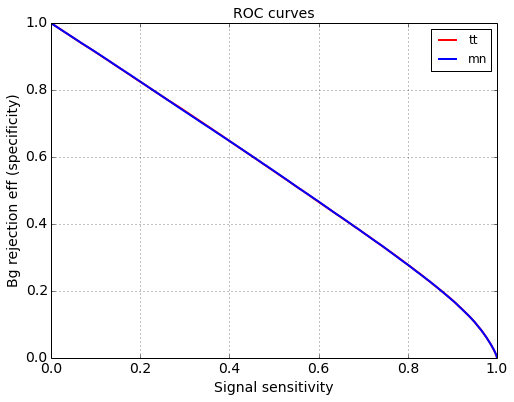

In [46]:
comparison_report.roc()

Default prediction
Default prediction


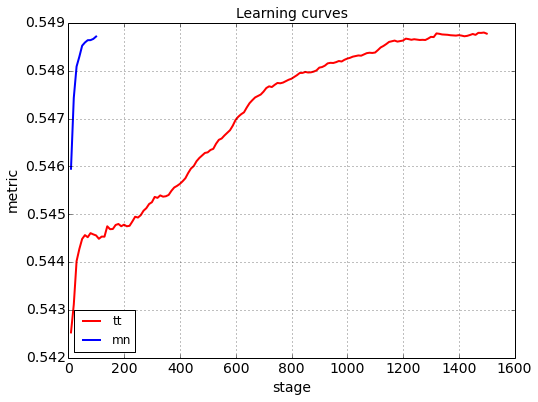

In [47]:
comparison_report.learning_curve(RocAuc(), steps=10)

In [48]:
mn_folding.estimators[0].get_feature_importances().sort('effect', ascending=False)

,effect,efficiency,information
IPs,1.000000,0.624262,0.903290
partPt,0.838848,0.503523,0.939417
proj,0.504631,0.311794,0.912644
IP,0.469812,0.293165,0.903665
diff_pt,0.398791,0.246065,0.913881
max_PID_mu_e,0.373053,0.221064,0.951583
veloch,0.311251,0.188956,0.928848
IPPU,0.259602,0.208678,0.701498
PIDNNk,0.228805,0.135288,0.953675
PIDNNm,0.208905,1.000000,0.117799


---------

### Forest idea

In [94]:
temp_probs = est_choose_RT.predict_proba(data_sw_passed)[:, 1]
mask = ((flat_ss(temp_probs) < 0.2) & (data_sw_passed.label == 0)) | \
       ((flat_os(temp_probs) > 0.4) & (data_sw_passed.label == 1))

KFold prediction using folds column


In [95]:
target_preselection

array([ 0.,  0.,  1., ...,  1.,  1.,  1.])

In [96]:
base = RandomForestClassifier(n_estimators=300, max_depth=8, min_samples_leaf=100, n_jobs=8)
forest_preselection_lds = LabeledDataStorage(data_sw_passed, mask * 1, data_sw_passed.N_sig_sw)
forest_preselection = FoldingClassifier(base, features=features, random_state=11)
%time forest_preselection.fit_lds(forest_preselection_lds)
pass

CPU times: user 24min 56s, sys: 144 ms, total: 24min 57s
Wall time: 28min 7s


In [97]:
report = ClassificationReport({'rf': forest_preselection}, forest_preselection_lds)

KFold prediction using folds column


In [98]:
report.compute_metric(RocAuc())

OrderedDict([('rf', 0.62047373542787521)])

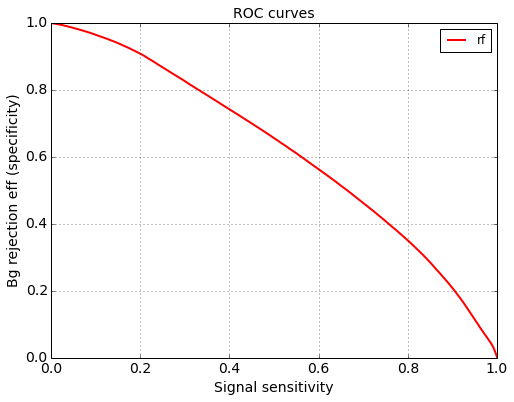

In [99]:
report.roc()

In [139]:
prob = forest_preselection.predict_proba(data_sw_passed)[:, 1]
data_sw_passed_preselected = data_sw_passed[prob > 0.45]
prob = forest_preselection.predict_proba(data_sw_not_passed)[:, 1]
data_sw_not_passed_preselected = data_sw_not_passed[prob > 0.45]

KFold prediction using folds column
KFold prediction using folds column


In [140]:
get_events_statistics(data_sw_passed_preselected)

{'Events': 281486, 'tracks': 399141}

In [ ]:
data_sw_passed_preselected_lds = LabeledDataStorage(data_sw_passed_preselected, data_sw_passed_preselected.label, 
                                                    sample_weight=data_sw_passed_preselected.N_sig_sw.values)


In [ ]:
tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=3000, depth=6, pretransform_needed=True, 
                                  max_features=15, loss=LogLossFunction(regularization=100))
tt_folding_preselected = FoldingClassifier(tt_base, n_folds=2, random_state=11, 
                                           ipc_profile='ssh-ipy', features=features)
%time tt_folding_preselected.fit_lds(data_sw_passed_preselected_lds)
pass

In [ ]:
report = ClassificationReport({'tt': tt_folding_preselected}, data_sw_passed_preselected_lds)
report.learning_curve(RocAuc())

### Forest selection

In [49]:
temp_probs = est_choose_RT.predict_proba(data_sw_passed)[:, 1]
mask = ((flat_ss(temp_probs) < 0.6) & (data_sw_passed.label == 0)) | \
       ((flat_os(temp_probs) > 0.2) & (data_sw_passed.label == 1))
data_sw_passed_rf_selected = data_sw_passed[mask]
data_sw_passed_rf_not_selected = data_sw_passed[~mask]

KFold prediction using folds column


In [50]:
get_events_statistics(data_sw_passed_rf_selected)

{'Events': 351328, 'tracks': 559582}

In [51]:
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares',
                                     iterations=5000, regularization=0.02, sync=False)
mn_folding_forest = FoldingClassifier(mn_base, n_folds=2, random_state=11, 
                                      features=features)
data_sw_passed_rf_lds = LabeledDataStorage(data_sw_passed_rf_selected, data_sw_passed_rf_selected.label, 
                                       sample_weight=data_sw_passed_rf_selected.N_sig_sw.values)
%time mn_folding_forest.fit_lds(data_sw_passed_rf_lds)
pass

CPU times: user 16.7 s, sys: 676 ms, total: 17.4 s
Wall time: 37.5 s


KFold prediction using folds column
Default prediction


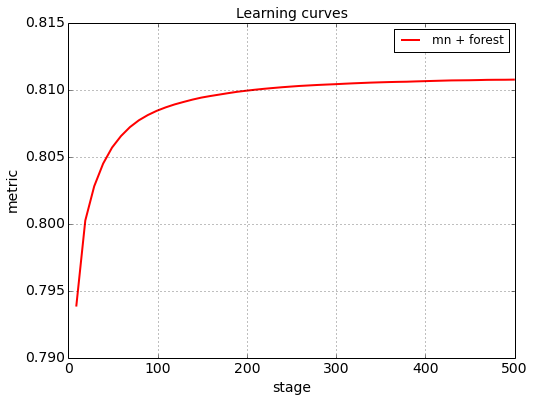

In [52]:
report = ClassificationReport({'mn + forest': mn_folding_forest}, data_sw_passed_rf_lds)
report.learning_curve(RocAuc())

----

### Top best selection

In [53]:
temp_probs = est_choose_RT.predict_proba(data_sw_passed)[:, 1]
data_sw_passed_top_selected, data_sw_passed_top_not_selected = get_best_tracks(data_sw_passed, temp_probs)

KFold prediction using folds column
409381 333695


In [54]:
print get_events_statistics(data_sw_passed_top_selected)
print get_events_statistics(data_sw_passed_top_not_selected)

{'tracks': 409381, 'Events': 409381}
{'tracks': 333695, 'Events': 205238}


In [55]:
mn_folding_top_forest_lds = LabeledDataStorage(data_sw_passed_top_selected, data_sw_passed_top_selected.label, 
                                               sample_weight=data_sw_passed_top_selected.N_sig_sw.values)

In [56]:
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares',
                                     iterations=3000, regularization=0.02, sync=False)
mn_folding_forest_top = FoldingClassifier(mn_base, n_folds=2, random_state=11, features=features)

%time mn_folding_forest_top.fit_lds(mn_folding_top_forest_lds)
pass

CPU times: user 12.4 s, sys: 432 ms, total: 12.8 s
Wall time: 28.5 s


KFold prediction using folds column
Default prediction


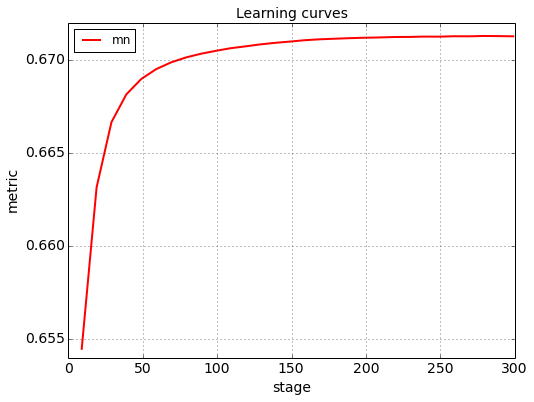

In [57]:
report = ClassificationReport({'mn': mn_folding_forest_top}, mn_folding_top_forest_lds)
report.learning_curve(RocAuc())

### Top pair selection

In [58]:
temp_probs = est_choose_RT.predict_proba(data_sw_passed)[:, 1]
data_sw_passed_pair_selected, data_sw_passed_pair_not_selected = get_pair_best_tracks(data_sw_passed, temp_probs)

KFold prediction using folds column
542837 200239


In [59]:
print get_events_statistics(data_sw_passed_pair_selected)
print get_events_statistics(data_sw_passed_pair_not_selected)

{'tracks': 542837, 'Events': 409381}
{'tracks': 200239, 'Events': 142507}


In [60]:
mn_folding_pair_forest_lds = LabeledDataStorage(data_sw_passed_pair_selected, data_sw_passed_pair_selected.label, 
                                           sample_weight=data_sw_passed_pair_selected.N_sig_sw.values)

In [61]:
mn_base = MatrixNetSkyGridClassifier(connection='skygrid', user_name='antares',
                                     iterations=4000, regularization=0.02, sync=False)
mn_folding_forest_pair = FoldingClassifier(mn_base, n_folds=2, random_state=11, features=features)

%time mn_folding_forest_pair.fit_lds(mn_folding_pair_forest_lds)
pass

CPU times: user 16.1 s, sys: 584 ms, total: 16.7 s
Wall time: 35.6 s


KFold prediction using folds column
Default prediction


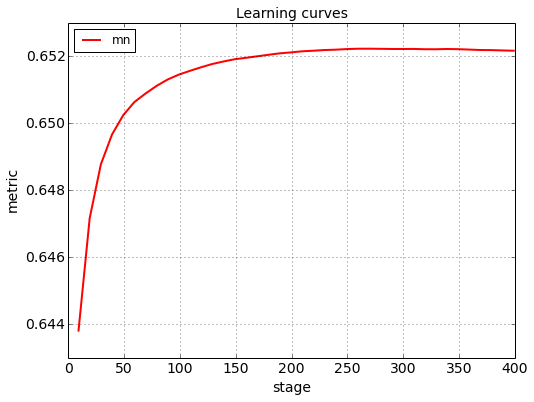

In [62]:
report = ClassificationReport({'mn': mn_folding_forest_pair}, mn_folding_pair_forest_lds)
report.learning_curve(RocAuc())

--------

# Calibration

In [63]:
from utils import get_result_with_bootstrap_for_given_part

In [64]:
models = []

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


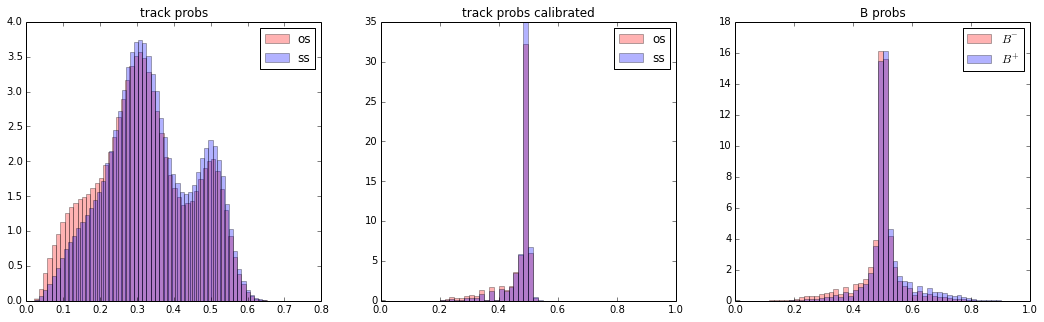

AUC for tagged: 0.587269370944 AUC with untag: 0.562933976828
mean AUC after calibration: 0.587315487224 4.00901301002e-07


In [65]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, 
                                                       mn_folding_forest_top, 
                                                       [data_sw_passed_top_selected, 
                                                        data_sw_passed_top_not_selected, 
                                                        data_sw_not_passed], 
                                                       'rf-top-mn-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


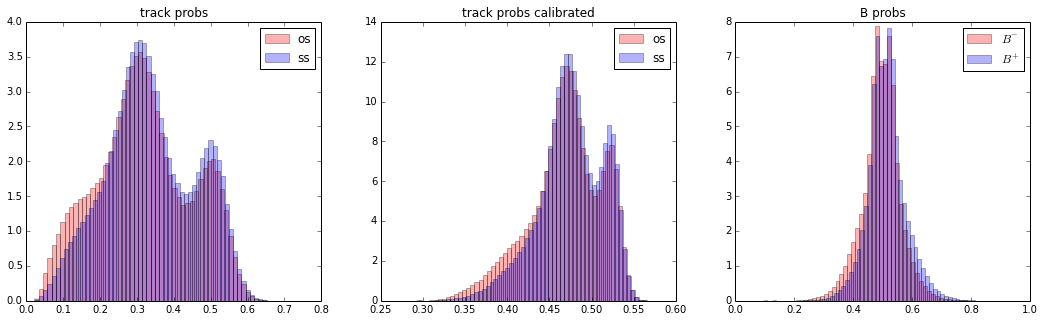

AUC for tagged: 0.584350157197 AUC with untag: 0.561252810411
mean AUC after calibration: 0.584092391533 9.20827141577e-07


In [66]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, 
                                                       mn_folding_forest_top, 
                                                      [data_sw_passed_top_selected,
                                                       data_sw_passed_top_not_selected,
                                                       data_sw_not_passed], 
                                                      'rf-top-mn-log', logistic=True))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


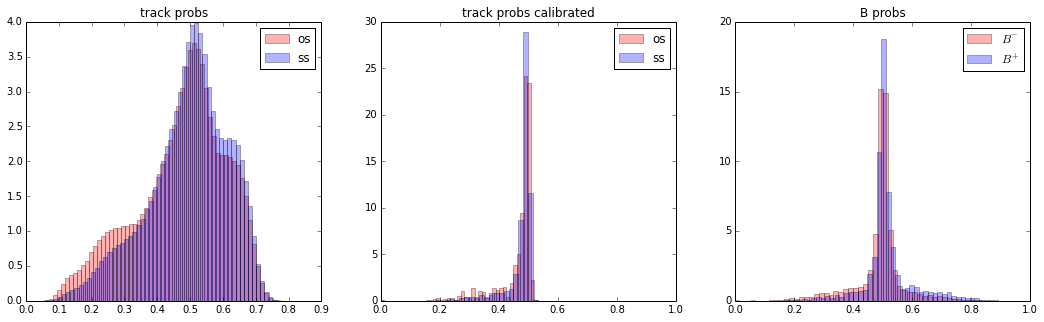

AUC for tagged: 0.589048610937 AUC with untag: 0.563772628527
mean AUC after calibration: 0.589163794309 1.14960444697e-06


In [67]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, 
                                                       mn_folding_forest_pair, 
                                                       [data_sw_passed_pair_selected, 
                                                        data_sw_passed_pair_not_selected, 
                                                        data_sw_not_passed], 
                                                       'rf-pair-top-mn-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


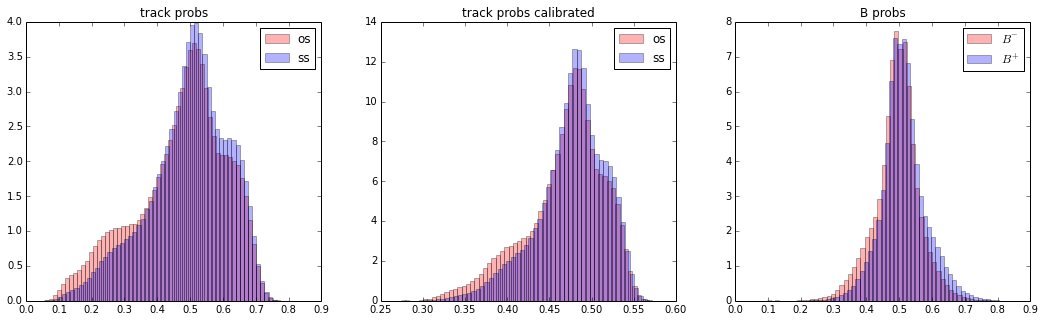

AUC for tagged: 0.587052801674 AUC with untag: 0.562661959383
mean AUC after calibration: 0.58691285176 1.00200786614e-06


In [68]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, 
                                                       mn_folding_forest_pair, 
                                                       [data_sw_passed_pair_selected, 
                                                        data_sw_passed_pair_not_selected, 
                                                        data_sw_not_passed], 
                                                       'rf-pair-top-mn-log', logistic=True))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


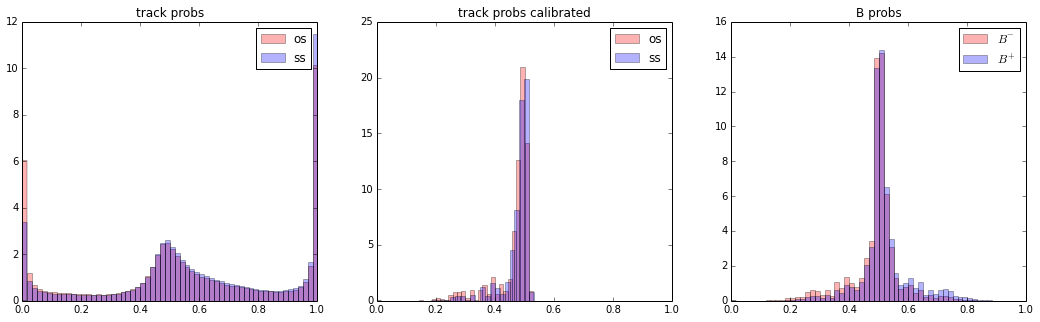

AUC for tagged: 0.588614873793 AUC with untag: 0.563329864747
mean AUC after calibration: 0.588659701014 4.71163320148e-07


In [69]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta,
                                                       mn_folding_forest, 
                                                      [data_sw_passed_rf_selected,
                                                       data_sw_passed_rf_not_selected, 
                                                       data_sw_not_passed], 
                                                      'rf-mn-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


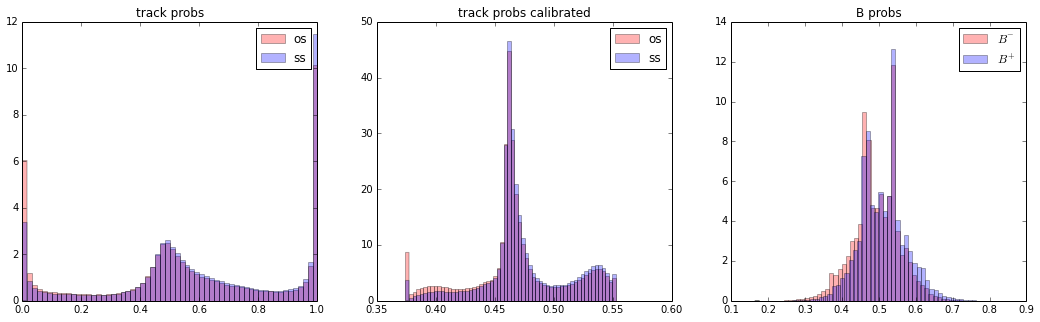

AUC for tagged: 0.583451654175 AUC with untag: 0.560836950217
mean AUC after calibration: 0.583376669125 8.23738792249e-07


In [70]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta,
                                                       mn_folding_forest, 
                                                      [data_sw_passed_rf_selected,
                                                       data_sw_passed_rf_not_selected,
                                                       data_sw_not_passed], 
                                                      'rf-mn-log', logistic=True))

KFold prediction using folds column
KFold prediction using folds column


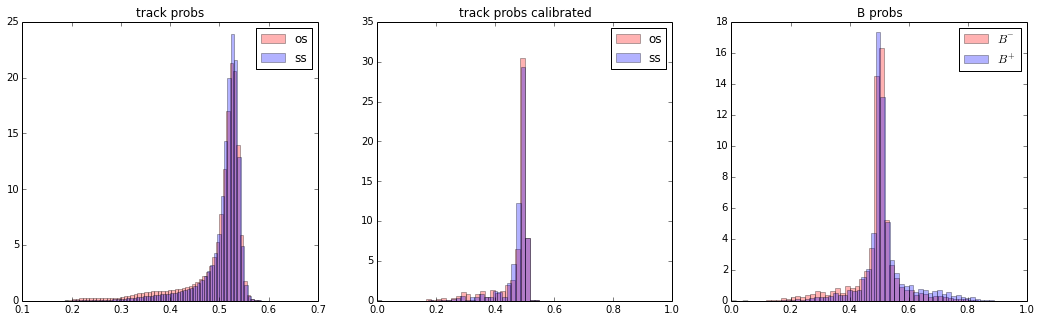

AUC for tagged: 0.588158047533 AUC with untag: 0.5628636722
mean AUC after calibration: 0.587922866897 8.40930502253e-07


In [71]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 'tt-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column


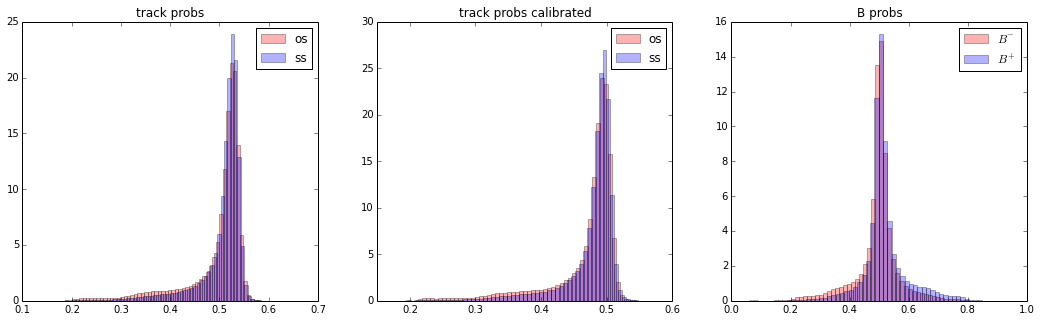

AUC for tagged: 0.588464050995 AUC with untag: 0.563161363154
mean AUC after calibration: 0.588545756838 5.44131337592e-07


In [72]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 'tt-log', logistic=True))

KFold prediction using folds column
KFold prediction using folds column


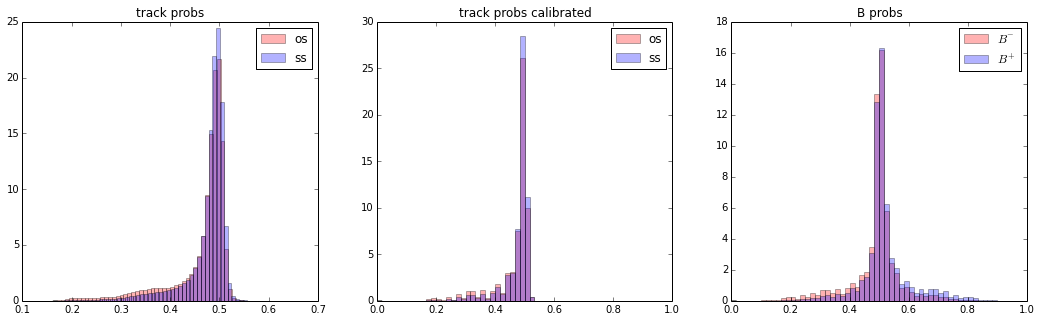

AUC for tagged: 0.588287147589 AUC with untag: 0.563222343886
mean AUC after calibration: 0.588183885576 4.09447952123e-07


In [73]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, mn_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 'mn-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column


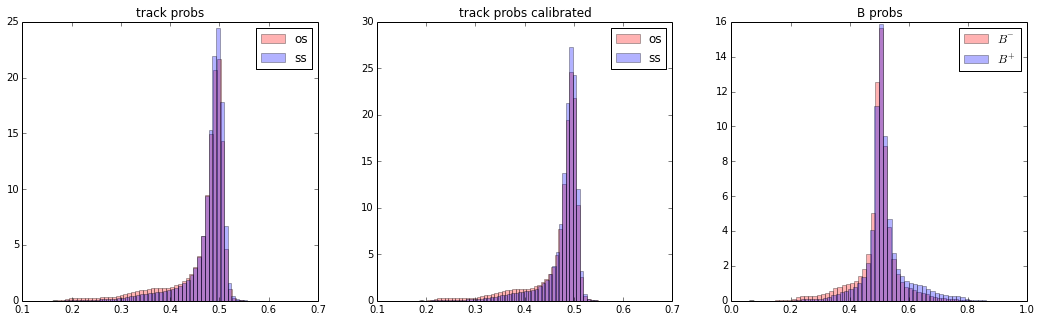

AUC for tagged: 0.588305894009 AUC with untag: 0.563336967511
mean AUC after calibration: 0.588475492962 9.36373432383e-07


In [75]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, mn_folding, 
                                                      [data_sw_passed, data_sw_not_passed], 'mn-log', logistic=True))

KFold prediction using folds column
KFold prediction using folds column


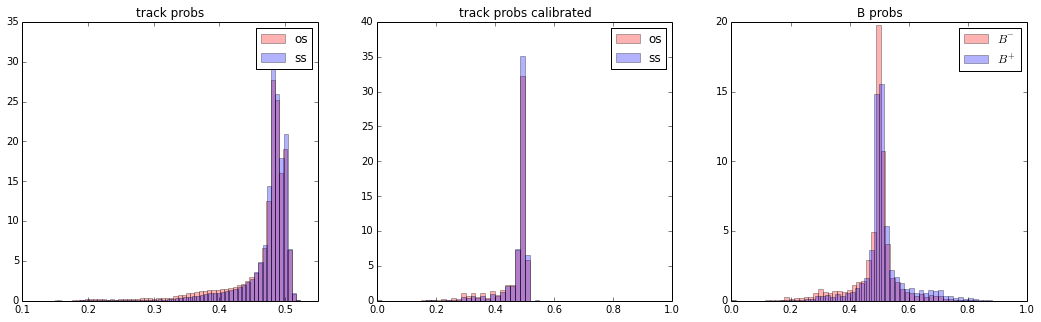

AUC for tagged: 0.587633340869 AUC with untag: 0.562806207728
mean AUC after calibration: 0.587735028527 7.48594214133e-07


In [76]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, est_choose_RT, 
                                                      [data_sw_passed, data_sw_not_passed], 'rf-iso', logistic=False))

KFold prediction using folds column
KFold prediction using folds column


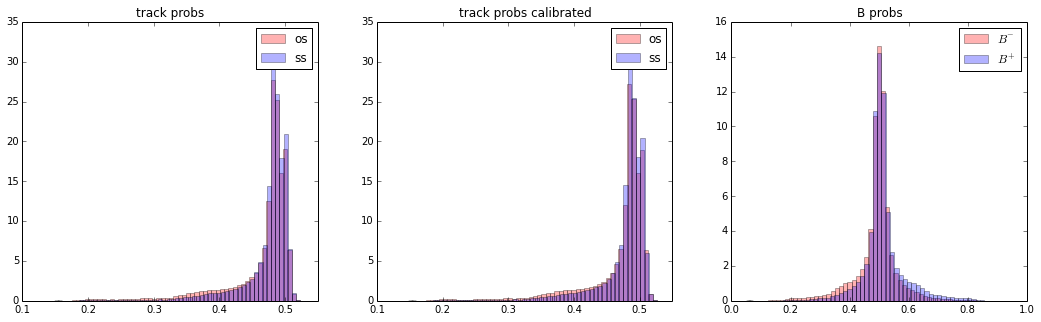

AUC for tagged: 0.587674959419 AUC with untag: 0.562325066873
mean AUC after calibration: 0.587549291625 4.0876245076e-07


In [77]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, est_choose_RT, 
                                                      [data_sw_passed, data_sw_not_passed], 'rf-log', logistic=True))

In [ ]:
N_B_passed = float(get_events_number(data_sw_passed_preselected)) + float(get_events_number(data_sw_not_passed_preselected))
tagging_efficiency_preselected = N_B_passed / get_N_B_events()
tagging_efficiency_preselected_delta = sqrt(N_B_passed) / get_N_B_events()
tagging_efficiency_preselected, tagging_efficiency_preselected_delta

In [ ]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency_preselected,
                                                       tagging_efficiency_preselected_delta, 
                                                       tt_folding_preselected, 
                                                      [data_sw_passed_preselected, data_sw_not_passed_preselected], 
                                                       'preselected4-tt-log', logistic=True))

## Comparison table of different models

In [ ]:
pandas.set_option('display.precision', 8)
result = pandas.concat(models)
result.index = result.name
result.drop('name', axis=1)

--------------------------

## Implementing best tracking

In [79]:
from utils import prepare_B_data_for_given_part

KFold prediction using folds column
KFold prediction using folds column


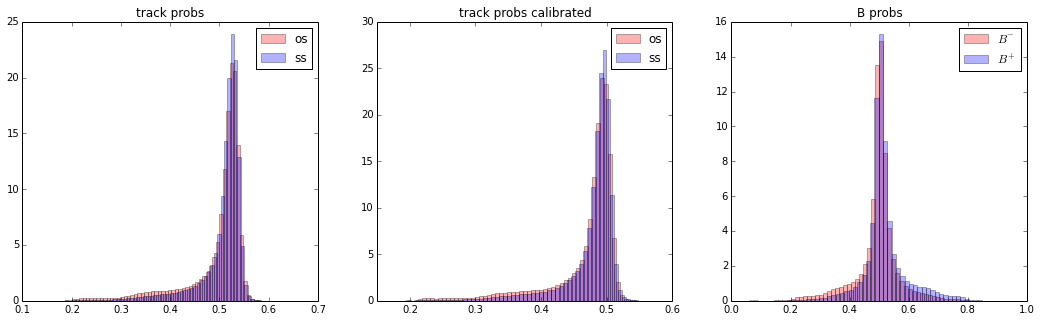

AUC for tagged: 0.588464050995 AUC with untag: 0.563161363154


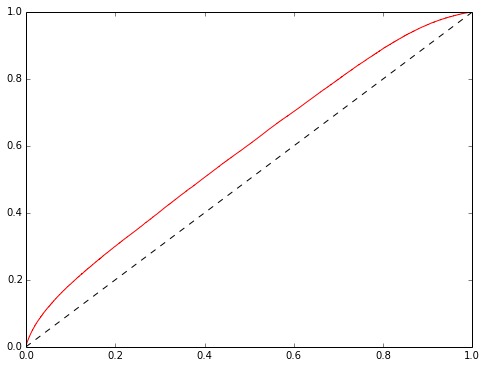

In [80]:
Bdata_prepared = prepare_B_data_for_given_part(tt_folding, [data_sw_passed, data_sw_not_passed], logistic=True)

In [81]:
Bdata_prepared.to_csv('models/Bdata_tracks.csv', header=True, index=False)